In [ ]:
# comment out `import tensorflow as tf` from `mimi/utils.py` and `mimi/models.py`, 
# otherwise hand tracking setup will hang

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import division

from copy import deepcopy
import pickle
import os
import uuid

import scipy
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
import matplotlib as mpl

from mimi import envs
from mimi import utils
from mimi import user_models
from mimi import opt
from mimi import reward_models
from mimi import models

In [3]:
data_dir = os.path.join(utils.data_dir, 'lander')

In [4]:
user_model = user_models.HumanHandUser()
import tensorflow as tf
utils.tf = tf
models.tf = tf

In [5]:
sess = utils.make_tf_session(gpu_mode=False)

In [6]:
max_ep_len = 500
step_delay = 0.02
reset_delay = 1

In [7]:
user_model = user_models.HumanHandUser()

In [8]:
env = envs.LanderEnv(
  sess,
  user_model,
  max_ep_len=max_ep_len,
  reset_delay=reset_delay,
  step_delay=step_delay
)

In [9]:
mi_model_init_args = [sess]
mi_model_init_kwargs = {
  'n_env_obs_dim': env.n_min_env_obs_dim,
  'n_user_obs_dim': env.n_user_obs_dim,
  'n_act_dim': env.n_act_dim,
  'n_layers': 2,
  'layer_size': 64
}
mi_model_train_kwargs = {
  'iterations': 1000,
  'ftol': 1e-6,
  'learning_rate': 1e-3,
  'batch_size': 64,
  'val_update_freq': None,
  'verbose': False,
  'warm_start': False
}

In [10]:
reward_model = reward_models.MIRewardModel(
  env,
  mi_model_init_args,
  mi_model_init_kwargs,
  mi_model_train_kwargs,
  use_min_env_obs=True
)




Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [11]:
true_rew_of_rollout = lambda rollout: 1 if rollout[-1][-1]['succ'] else 0
true_reward_model = lambda rollouts: np.mean([true_rew_of_rollout(rollout) for rollout in rollouts])

In [ ]:
gp_optimizer = opt.GP(
  env,
  reward_model,
  param_bounds=(-1., 1.)
)

In [ ]:
gp_min_kwargs = {'n_initial_points': 3}
ep_kwargs = {'init_delay': 1, 'render': True}
n_eps_per_pol = 10

In [ ]:
gp_policy, res = gp_optimizer.run(
  n_pols=50,
  n_eps_per_pol=n_eps_per_pol,
  gp_min_kwargs=gp_min_kwargs,
  ep_kwargs=ep_kwargs,
  reward_model_train_kwargs=mi_model_train_kwargs
)

In [ ]:
#eval_data_of_pol.extend(gp_optimizer.eval_data_of_pol)

In [ ]:
eval_data_of_pol = gp_optimizer.eval_data_of_pol

In [ ]:
user_id = '0'

In [ ]:
gp_results_path = os.path.join(data_dir, user_id, 'gp_results.pkl')

In [ ]:
with open(gp_results_path, 'wb') as f:
  pickle.dump(eval_data_of_pol, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open(gp_results_path, 'rb') as f:
#  eval_data_of_pol = pickle.load(f)

In [ ]:
#x0, _, y0 = [list(z) for z in zip(*eval_data_of_pol)]
#gp_min_kwargs.update({'x0': x0, 'y0': y0})

In [25]:
perf_evals = []
for user_id in range(3):
  user_path = os.path.join(data_dir, str(user_id))
  if os.path.exists(user_path):
    gp_results_path = os.path.join(user_path, 'gp_results.pkl')
    with open(gp_results_path, 'rb') as f:
      eval_data_of_pol = pickle.load(f)
    true_rews_of_pol = [[true_reward_model([rollout]) for rollout in eval_data[1]] for eval_data in eval_data_of_pol]
    true_rew_of_pol = [true_reward_model(eval_data[1]) for eval_data in eval_data_of_pol]
    rew_of_pol = [eval_data[2] for eval_data in eval_data_of_pol]
    
    baseline_true_rewards = true_rew_of_pol[:3]
    baseline_rewards = rew_of_pol[:3]
    true_rews = sum(true_rews_of_pol, [])
    perf_evals.append({
      'true_rews': true_rews, 
      'true_rew': true_rew_of_pol,
      'rews': rew_of_pol,
      'rew_xs': np.cumsum([len(eval_data[1]) for eval_data in eval_data_of_pol]),
      'true_xs': np.cumsum(np.ones(len(true_rews)))-1,
      'baseline_true_reward': np.mean(baseline_true_rewards),
      'baseline_reward': np.mean(baseline_rewards)
    })

In [26]:
mpl.rcParams.update({'font.size': 12})

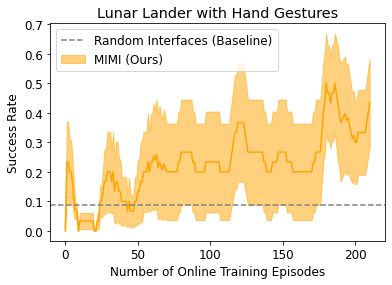

In [22]:
plt.title('Lunar Lander with Hand Gestures')
plt.xlabel('Number of Online Training Episodes')
plt.ylabel('Success Rate')
utils.plot_perf_evals(perf_evals, 'true_xs', 'true_rews', label='MIMI (Ours)', smooth_win=10, color='orange')
plt.axhline(y=np.mean([perf['baseline_true_reward'] for perf in perf_evals]), linestyle='--', color='gray', label='Random Interfaces (Baseline)')
plt.legend(loc='upper left')
#plt.savefig(os.path.join(data_dir, 'lander-study-truerew-vs-eps.pdf'), bbox_inches='tight')
plt.show()

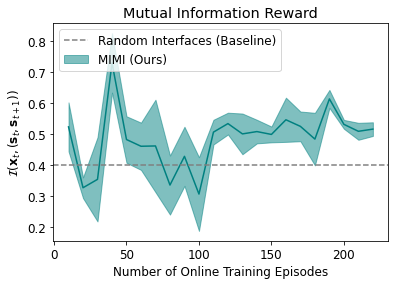

In [23]:
plt.title('Mutual Information Reward')
plt.xlabel('Number of Online Training Episodes')
plt.ylabel(r"$\mathcal{I}(\mathbf{x}_t, (\mathbf{s}_t, \mathbf{s}_{t+1}))$")
utils.plot_perf_evals(perf_evals, 'rew_xs', 'rews', label='MIMI (Ours)', smooth_win=1, color='teal')
plt.axhline(y=np.mean([perf['baseline_reward'] for perf in perf_evals]), linestyle='--', color='gray', label='Random Interfaces (Baseline)')
plt.legend(loc='upper left')
plt.savefig(os.path.join(data_dir, 'lander-study-rew-vs-eps.pdf'), bbox_inches='tight')
plt.show()

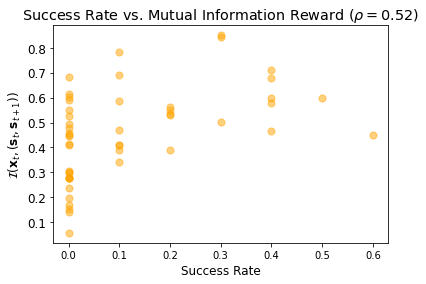

In [27]:
xs = sum([perf_eval['true_rew'] for perf_eval in perf_evals], [])
ys = sum([perf_eval['rews'] for perf_eval in perf_evals], [])
rho = scipy.stats.spearmanr(xs, ys)[0]
plt.title(r'Success Rate vs. Mutual Information Reward ($\rho = %0.2f$)' % rho)
plt.xlabel('Success Rate')
plt.ylabel(r"$\mathcal{I}(\mathbf{x}_t, (\mathbf{s}_t, \mathbf{s}_{t+1}))$")
plt.scatter(
  xs, 
  ys,
  color='orange',
  s=50,
  alpha=0.5
)
plt.xticks(fontsize=10)
plt.savefig(os.path.join(data_dir, 'lander-study-truerew-vs-mi.pdf'), bbox_inches='tight')
plt.show()